In [109]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.impute import SimpleImputer
from sklearn.calibration import CalibratedClassifierCV
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GroupKFold
from sklearn.metrics import log_loss
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

In [15]:
df_train = pd.read_csv('../nss_capstone/df_train_07_20.csv').drop(columns='Unnamed: 0')
df_train

,game_id,Date,VH,Team,Final,ML,ML_pct,Open Total,Close Total,Open Spread,...,W/L_H_fav,W/L_V_fav,W/L_H_dog,W/L_V_dog,ATS_H_fav,ATS_V_fav,ATS_H_dog,ATS_V_dog,Push,W/L_bool
0,1324,2020-10-11,N,LALakers,106,-250.0,0.71,NaN,NaN,-5.0,...,0,0,0,0,0,0,0,0,0,1
1,1324,2020-10-11,N,Miami,93,210.0,0.32,216.5,215.0,5.0,...,0,0,0,0,0,0,0,0,0,0
2,1325,2020-10-09,N,LALakers,108,-340.0,0.77,NaN,NaN,-7.5,...,0,0,0,0,0,0,0,0,0,0
3,1325,2020-10-09,N,Miami,111,280.0,0.26,217.0,215.0,7.5,...,0,0,1,1,0,0,0,0,0,1
4,1326,2020-10-06,N,LALakers,102,-330.0,0.77,NaN,NaN,-7.5,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33323,17985,2007-10-30,H,LALakers,93,190.0,0.34,191.0,199.0,2.5,...,0,0,0,0,0,0,1,0,0,0
33324,17986,2007-10-30,H,GoldenState,96,-120.0,0.55,NaN,NaN,-3.0,...,0,0,0,0,0,0,0,0,0,0
33325,17986,2007-10-30,V,Utah,117,100.0,0.50,214.5,212.0,3.0,...,0,0,0,1,0,0,0,0,0,1
33326,17987,2007-10-30,H,SanAntonio,106,-1400.0,0.93,NaN,NaN,-12.5,...,1,0,0,0,0,0,0,0,0,1


In [16]:
df_train['Payout'] = df_train.groupby('game_id')['ML'].transform(lambda x: (100 / abs(x.iloc[0])) * 100)
df_train.loc[df_train.groupby('game_id').cumcount() > 0, 'Payout'] = None

df_train['Payout'] = pd.to_numeric(df_train['Payout'], errors='coerce')

In [17]:
# # Replace NaN values in the second row with corresponding payout values
second_row_mask = df_train.groupby('game_id').cumcount() == 1
df_train.loc[second_row_mask, 'Payout'] = df_train.loc[second_row_mask, 'ML'].abs()

In [18]:
df_train['Payout'] = df_train['Payout'].apply(lambda x: math.ceil(x * 100) / 100 if not math.isnan(x) else x)

In [20]:
df_train.to_csv('../nss_capstone/df_train_07_20.csv')

In [19]:
df_train

,game_id,Date,VH,Team,Final,ML,ML_pct,Open Total,Close Total,Open Spread,...,W/L_V_fav,W/L_H_dog,W/L_V_dog,ATS_H_fav,ATS_V_fav,ATS_H_dog,ATS_V_dog,Push,W/L_bool,Payout
0,1324,2020-10-11,N,LALakers,106,-250.0,0.71,NaN,NaN,-5.0,...,0,0,0,0,0,0,0,0,1,40.00
1,1324,2020-10-11,N,Miami,93,210.0,0.32,216.5,215.0,5.0,...,0,0,0,0,0,0,0,0,0,210.00
2,1325,2020-10-09,N,LALakers,108,-340.0,0.77,NaN,NaN,-7.5,...,0,0,0,0,0,0,0,0,0,29.42
3,1325,2020-10-09,N,Miami,111,280.0,0.26,217.0,215.0,7.5,...,0,1,1,0,0,0,0,0,1,280.00
4,1326,2020-10-06,N,LALakers,102,-330.0,0.77,NaN,NaN,-7.5,...,0,0,0,0,0,0,0,0,1,30.31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33323,17985,2007-10-30,H,LALakers,93,190.0,0.34,191.0,199.0,2.5,...,0,0,0,0,0,1,0,0,0,190.00
33324,17986,2007-10-30,H,GoldenState,96,-120.0,0.55,NaN,NaN,-3.0,...,0,0,0,0,0,0,0,0,0,83.34
33325,17986,2007-10-30,V,Utah,117,100.0,0.50,214.5,212.0,3.0,...,0,0,1,0,0,0,0,0,1,100.00
33326,17987,2007-10-30,H,SanAntonio,106,-1400.0,0.93,NaN,NaN,-12.5,...,0,0,0,0,0,0,0,0,1,7.15


In [145]:
#payout.to_csv('../nss_capstone/payout.csv')

                        *******'ML_pct'***********

In [26]:
# 10 folds

payout = pd.read_csv('../nss_capstone/df_train_07_20.csv').drop(columns='Unnamed: 0')

variables = ['ML_pct'] 
X = payout[variables]
y = payout['W/L_bool']

imputer = SimpleImputer(strategy='mean')
imputer.fit(X)
X_imputed = imputer.transform(X)

base_classifier = GradientBoostingClassifier()
calibrated_classifier = CalibratedClassifierCV(base_classifier, method='sigmoid')

# Define the group indices based on game IDs
group_indices = payout['game_id'].values // 2  # Divide game IDs by 2 to group every two rows as one game

# Perform 5-fold cross-validation with grouping
num_folds = 10
group_kfold = GroupKFold(n_splits=num_folds)

# Calculate cross-validation scores
#scores = cross_val_score(calibrated_classifier, X_imputed, y, cv=group_kfold, groups=group_indices)

# print("Cross-validation scores:", scores)
# print("Mean score:", np.mean(scores))

profits = []
replaced_wagers = []
bets_won = []
bets_lost = []

# Define the group indices based on game IDs
group_indices = payout['game_id'].values  

group_kfold = GroupKFold(n_splits=num_folds)

for train_index, test_index in group_kfold.split(X_imputed, y, groups=group_indices):
    X_train, X_test = X_imputed[train_index], X_imputed[test_index]
    y_train, y_test = y[train_index], y[test_index]

    calibrated_classifier.fit(X_train, y_train)
   
    predicted_probabilities = calibrated_classifier.predict_proba(X_test)[:, 1]
    closing_moneyline_odds = payout.loc[test_index, 'ML_pct'].reset_index(drop=True)

    percentage_differences = predicted_probabilities - closing_moneyline_odds    
   

    payouts = payout.loc[test_index, 'Payout'].reset_index(drop=True)
    results = y_test.reset_index(drop = True)
    
    profit_fold = []
    
    #for loop here to loop through range of thresh val and stores as a list (list of lists, convert df)
    for threshold in np.linspace(start = 0, stop = .1, num = 101):
        
    
        selected_bets = percentage_differences >= threshold

        wager = 100  # Set the wager amount to $100

        bets_won = selected_bets * results * payouts
        bets_lost = selected_bets * (1-results) * -wager
        profit = bets_won.sum() + bets_lost.sum()
        profit_fold.append(profit)
    
    profits.append(profit_fold)

    replaced_wagers.append(np.sum(selected_bets))

In [27]:
pd.DataFrame(profits, columns = np.linspace(start = 0, stop = .1, num = 101))#.mean()#.sort_values()

,0.000,0.001,0.002,0.003,0.004,0.005,0.006,0.007,0.008,0.009,...,0.091,0.092,0.093,0.094,0.095,0.096,0.097,0.098,0.099,0.100
0,671.30,1640.97,1640.97,1835.97,1238.05,1238.05,1238.05,1238.00,1238.00,920.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-10044.18,-9182.18,-9182.18,-9182.18,-9182.18,-9182.18,-8079.18,-7569.18,-7569.18,-7269.18,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-4489.44,-4889.44,-4290.66,-3190.05,-3859.05,-3059.05,-2689.05,-1589.05,-584.05,-874.05,...,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0
3,-9846.44,-11066.44,-10631.44,-9431.44,-6846.44,-5846.44,-4366.44,-4140.00,-1650.00,-2060.00,...,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0
4,-5117.00,-5267.00,-5425.00,-5425.00,-5195.00,-2345.00,-2345.00,-2345.00,-330.00,1250.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,-148.09,-1438.04,-1578.04,-2757.04,-2757.04,-1020.04,279.96,329.96,-293.00,-343.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,-11511.00,-10421.00,-9671.00,-9071.00,-8118.00,-8118.00,-8118.00,-7718.00,-7643.00,-7643.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,-6839.51,-6560.61,-6560.61,-4580.61,-4580.61,-1647.32,-1647.32,-555.00,-1055.00,-1055.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,-10258.71,-8508.71,-8468.71,-6420.00,-6420.00,-4935.00,-4340.00,-4340.00,-4340.00,-4340.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,-3195.65,-3195.65,-4541.65,-4541.65,-4539.00,-5802.00,-3921.00,-421.00,-421.00,-421.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
ML_pct_folds_10 = pd.DataFrame(profits, columns = np.linspace(start = 0, stop = .1, num = 101))

In [ ]:
ML_pct_folds_30[0.03].mean()

In [28]:
# Kfold (10 folds) ML_pct plots

desired_num_folds = 10

# Create subplots with shared x-axis
fig = make_subplots(rows=desired_num_folds, cols=1, shared_xaxes=True)

# Define fold labels for the dropdown menu, limited to the desired number of folds
fold_labels = [f"Fold {i+1}" for i in range(desired_num_folds)]

# Iterate over each fold up to the desired number and add a trace to the corresponding subplot
for fold, profit_fold in enumerate(profits[:desired_num_folds]):
    # Create a trace for the current fold
    trace = go.Scatter(
        x=np.linspace(start=0.1, stop=0.5, num=101),
        y=profit_fold,
        mode='lines',
        name=f"Fold {fold+1}"
    )

    # Add the trace to the subplot
    fig.add_trace(trace, row=fold+1, col=1)

# Update layout and add a dropdown menu limited to the desired number of folds
fig.update_layout(
    title="K-fold Results with 10 Folds",
    xaxis=dict(title=""),
    yaxis=dict(title=""),
    updatemenus=[
        dict(
            active=0,
            buttons=list([ dict(label="Show All Folds", method="update", args=[{"visible": [True] * len(fig.data)}]),
                *[
                dict(label=fold_label, method="update", args=[{"visible": [fold == i for i in range(desired_num_folds)]}])
                for fold_label, fold in zip(fold_labels, range(desired_num_folds))
            ]]),
            x=1.1,  # Set the x position of the dropdown menu to the right of the plot
            y=1.15,  # Set the y position of the dropdown menu above the plot
            xanchor='right',  # Anchor the x position to the right
            yanchor='top'  # Anchor the y position to the top
                          )
    ],
    width=800,  # Set the width of the plot
    height=650  # Set the height of the plot
    )


# Move the legend to the top right corner
fig.update_layout(legend=dict(x=1, y=1, xanchor='left', yanchor='top'))

# Show the plot
fig.show()

In [29]:
# 20 folds

payout = pd.read_csv('../nss_capstone/df_train_07_20.csv').drop(columns='Unnamed: 0')

variables = ['ML_pct'] 
X = payout[variables]
y = payout['W/L_bool']

imputer = SimpleImputer(strategy='mean')
imputer.fit(X)
X_imputed = imputer.transform(X)

base_classifier = GradientBoostingClassifier()
calibrated_classifier = CalibratedClassifierCV(base_classifier, method='sigmoid')

# Define the group indices based on game IDs
group_indices = payout['game_id'].values // 2  # Divide game IDs by 2 to group every two rows as one game

# Perform 5-fold cross-validation with grouping
num_folds = 20
group_kfold = GroupKFold(n_splits=num_folds)

# Calculate cross-validation scores
#scores = cross_val_score(calibrated_classifier, X_imputed, y, cv=group_kfold, groups=group_indices)

# print("Cross-validation scores:", scores)
# print("Mean score:", np.mean(scores))

profits = []
replaced_wagers = []
bets_won = []
bets_lost = []

# Define the group indices based on game IDs
group_indices = payout['game_id'].values  

group_kfold = GroupKFold(n_splits=num_folds)

for train_index, test_index in group_kfold.split(X_imputed, y, groups=group_indices):
    X_train, X_test = X_imputed[train_index], X_imputed[test_index]
    y_train, y_test = y[train_index], y[test_index]

    calibrated_classifier.fit(X_train, y_train)
   
    predicted_probabilities = calibrated_classifier.predict_proba(X_test)[:, 1]
    closing_moneyline_odds = payout.loc[test_index, 'ML_pct'].reset_index(drop=True)

    percentage_differences = predicted_probabilities - closing_moneyline_odds    
   

    payouts = payout.loc[test_index, 'Payout'].reset_index(drop=True)
    results = y_test.reset_index(drop = True)
    
    profit_fold = []
    
    #for loop here to loop through range of thresh val and stores as a list (list of lists, convert df)
    for threshold in np.linspace(start = 0, stop = .1, num = 101):
        
    
        selected_bets = percentage_differences >= threshold

        wager = 100  # Set the wager amount to $100

        bets_won = selected_bets * results * payouts
        bets_lost = selected_bets * (1-results) * -wager
        profit = bets_won.sum() + bets_lost.sum()
        profit_fold.append(profit)
    
    profits.append(profit_fold)

    replaced_wagers.append(np.sum(selected_bets))

In [33]:
pd.DataFrame(profits, columns = np.linspace(start = 0, stop = .1, num = 101))#.mean()#.sort_values()

,0.000,0.001,0.002,0.003,0.004,0.005,0.006,0.007,0.008,0.009,...,0.091,0.092,0.093,0.094,0.095,0.096,0.097,0.098,0.099,0.100
0,4201.95,3491.95,3486.95,2551.95,2986.56,1769.33,1769.33,1769.33,669.33,1272.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-7610.96,-7110.96,-6865.60,-7171.60,-7041.60,-5241.60,-5241.60,-5241.60,-5241.60,-5241.60,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-2935.15,-2725.15,-1825.15,-585.99,4.00,-330.00,-30.00,-225.00,-825.00,-1065.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-3785.65,-3635.65,-2735.65,-1360.65,34.35,192.00,192.00,192.00,-23.00,147.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-2320.00,-330.00,-330.00,-330.00,-775.00,-775.00,-775.00,-775.00,-770.00,-770.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1188.04,638.04,1458.04,1458.04,760.24,760.24,1556.24,1556.24,1556.24,1947.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,-4644.00,-4074.00,-4074.00,-3724.00,-3724.00,-2223.00,-2023.00,-1268.00,-1503.00,-1503.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,-2239.16,-2339.16,-2272.56,-2177.56,-2269.00,-2269.00,-984.00,-850.00,-850.00,-1050.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,-4033.65,-3638.65,-3492.15,-3495.63,-1840.00,-1265.00,-1490.00,-1490.00,-1490.00,-1090.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,-1129.39,-229.39,733.00,1743.00,1743.00,1403.00,1403.00,1403.00,1323.00,1323.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
ML_pct_folds_20 = pd.DataFrame(profits, columns = np.linspace(start = 0, stop = .1, num = 101))

In [35]:
ML_pct_folds_20[0.03].mean()

193.4

In [36]:
# Kfold (20 folds) ML_pct plots

desired_num_folds = 20

# Create subplots with shared x-axis
fig = make_subplots(rows=desired_num_folds, cols=1, shared_xaxes=True)

# Define fold labels for the dropdown menu, limited to the desired number of folds
fold_labels = [f"Fold {i+1}" for i in range(desired_num_folds)]

# Iterate over each fold up to the desired number and add a trace to the corresponding subplot
for fold, profit_fold in enumerate(profits[:desired_num_folds]):
    # Create a trace for the current fold
    trace = go.Scatter(
        x=np.linspace(start=0.1, stop=0.5, num=101),
        y=profit_fold,
        mode='lines',
        name=f"Fold {fold+1}"
    )

    # Add the trace to the subplot
    fig.add_trace(trace, row=fold+1, col=1)

# Update layout and add a dropdown menu limited to the desired number of folds
fig.update_layout(
    title="K-fold Results with 20 Folds",
    xaxis=dict(title=""),
    yaxis=dict(title=""),
    updatemenus=[
        dict(
            active=0,
            buttons=list([ dict(label="Show All Folds", method="update", args=[{"visible": [True] * len(fig.data)}]),
                *[
                dict(label=fold_label, method="update", args=[{"visible": [fold == i for i in range(desired_num_folds)]}])
                for fold_label, fold in zip(fold_labels, range(desired_num_folds))
            ]]),
            x=1.1,  # Set the x position of the dropdown menu to the right of the plot
            y=1.15,  # Set the y position of the dropdown menu above the plot
            xanchor='right',  # Anchor the x position to the right
            yanchor='top'  # Anchor the y position to the top
                          )
    ],
    width=900,  # Set the width of the plot
    height= 1050  # Set the height of the plot
    )


# Move the legend to the top right corner
fig.update_layout(legend=dict(x=1, y=1, xanchor='left', yanchor='top'))

# Show the plot
fig.show()

In [37]:
# 30 folds

payout = pd.read_csv('../nss_capstone/df_train_07_20.csv').drop(columns='Unnamed: 0')

variables = ['ML_pct'] 
X = payout[variables]
y = payout['W/L_bool']

imputer = SimpleImputer(strategy='mean')
imputer.fit(X)
X_imputed = imputer.transform(X)

base_classifier = GradientBoostingClassifier()
calibrated_classifier = CalibratedClassifierCV(base_classifier, method='sigmoid')

# Define the group indices based on game IDs
group_indices = payout['game_id'].values // 2  # Divide game IDs by 2 to group every two rows as one game

# Perform 5-fold cross-validation with grouping
num_folds = 30
group_kfold = GroupKFold(n_splits=num_folds)

# Calculate cross-validation scores
#scores = cross_val_score(calibrated_classifier, X_imputed, y, cv=group_kfold, groups=group_indices)

# print("Cross-validation scores:", scores)
# print("Mean score:", np.mean(scores))

profits = []
replaced_wagers = []
bets_won = []
bets_lost = []

# Define the group indices based on game IDs
group_indices = payout['game_id'].values  

group_kfold = GroupKFold(n_splits=num_folds)

for train_index, test_index in group_kfold.split(X_imputed, y, groups=group_indices):
    X_train, X_test = X_imputed[train_index], X_imputed[test_index]
    y_train, y_test = y[train_index], y[test_index]

    calibrated_classifier.fit(X_train, y_train)
   
    predicted_probabilities = calibrated_classifier.predict_proba(X_test)[:, 1]
    closing_moneyline_odds = payout.loc[test_index, 'ML_pct'].reset_index(drop=True)

    percentage_differences = predicted_probabilities - closing_moneyline_odds    
   

    payouts = payout.loc[test_index, 'Payout'].reset_index(drop=True)
    results = y_test.reset_index(drop = True)
    
    profit_fold = []
    
    #for loop here to loop through range of thresh val and stores as a list (list of lists, convert df)
    for threshold in np.linspace(start = 0, stop = .1, num = 101):
        
    
        selected_bets = percentage_differences >= threshold

        wager = 100  # Set the wager amount to $100

        bets_won = selected_bets * results * payouts
        bets_lost = selected_bets * (1-results) * -wager
        profit = bets_won.sum() + bets_lost.sum()
        profit_fold.append(profit)
    
    profits.append(profit_fold)

    replaced_wagers.append(np.sum(selected_bets))

In [38]:
pd.DataFrame(profits, columns = np.linspace(start = 0, stop = .1, num = 101))#.mean()#.sort_values()

,0.000,0.001,0.002,0.003,0.004,0.005,0.006,0.007,0.008,0.009,...,0.091,0.092,0.093,0.094,0.095,0.096,0.097,0.098,0.099,0.100
0,-265.68,634.32,1234.32,412.24,912.24,912.24,1657.00,1772.0,1772.0,972.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5.70,-300.30,199.70,983.00,993.00,743.00,423.00,423.0,423.0,608.0,...,118.0,118.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-677.58,-977.58,2104.42,2272.48,3007.00,3094.00,1144.00,1264.0,1264.0,1439.0,...,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0
3,-7625.00,-5830.00,-4765.00,-4535.00,-3835.00,-3835.00,-3145.00,-2245.0,-1845.0,-1835.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-4665.46,-4395.46,-3135.46,-2135.46,-2135.46,-1671.62,-1671.62,-1305.0,-905.0,-1705.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,-1286.41,-1030.41,-1990.41,-1756.76,-265.00,-265.00,-305.00,-305.0,-305.0,-460.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,-3929.56,-2895.00,-2740.00,-2040.00,-2040.00,-2040.00,-2040.00,-2940.0,-1240.0,-245.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,-1719.52,-1400.00,-1500.00,-705.00,-405.00,-405.00,-2005.00,-1940.0,-1940.0,-1940.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,-4458.97,-2958.97,-2108.97,-1113.97,-1113.97,-1360.00,-1485.00,-530.0,-530.0,-530.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,-1117.00,-617.00,183.00,473.00,473.00,258.00,258.00,-411.0,-411.0,-411.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [106]:
ML_pct_folds_30 = pd.DataFrame(profits, columns = np.linspace(start = 0, stop = .1, num = 101))#.mean().idxmax()

In [108]:
ML_pct_folds_30[0.033].sum()

13035.11

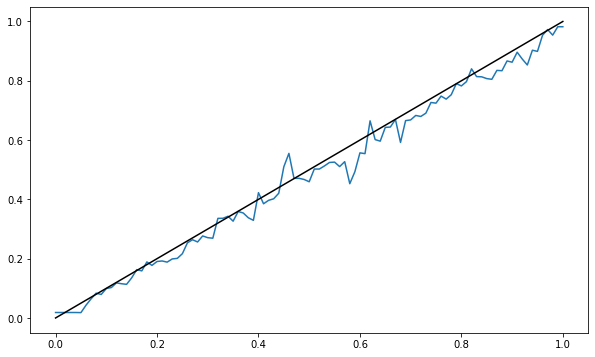

In [54]:


# plt.figure(figsize = (10,6))

# calibrated_classifier.predict_proba(np.linspace(start = 0, stop = 1, num = 101).reshape (-1,1))[:, 1]
# plt.plot(
# np.linspace(start = 0, stop = 1, num = 101),
# calibrated_classifier.predict_proba(np.linspace(start = 0, stop = 1, num = 101).reshape (-1,1))[:, 1])


# calibrated_classifier.predict_proba(np.linspace(start = 0, stop = 1, num = 101).reshape (-1,1))[:, 1]
# plt.plot(
# np.linspace(start = 0, stop = 1, num = 101),
# np.linspace(start = 0, stop = 1, num = 101), color = 'black')



In [67]:
predicted_probabilities = calibrated_classifier.predict_proba(X_test)[:, 1]
closing_moneyline_odds = payout.loc[test_index, 'ML_pct'].reset_index(drop=True)

percentage_differences = predicted_probabilities - closing_moneyline_odds    
selected_bets = percentage_differences >= threshold

payouts = payout.loc[test_index, 'Payout'].reset_index(drop=True)
results = y_test.reset_index(drop = True) 

bets_won = selected_bets * results * payouts
bets_lost = selected_bets * (1-results) * -wager
profit = bets_won.sum() + bets_lost.sum()
# wager = 100  # Set the wager amount to $100
# profit = np.sum(selected_bets * (wager * closing_moneyline_odds - wager))
# profits.append(profit)

# replaced_wagers.append(np.sum(selected_bets))
# bets_won.append(np.sum(selected_bets * y_test))  # Sum of bets won (replaced wagers)
# bets_lost.append(np.sum(selected_bets * (1 - y_test))) 

In [69]:
profit

1750.2099999999991

In [160]:
selected_bets.sum()*100

300

In [61]:
y_test.reset_index(drop = True) * payouts

0        64.52
1         0.00
2        35.72
3         0.00
4         0.00
         ...  
7189      0.00
7190      0.00
7191    105.00
7192      0.00
7193    100.00
Length: 7194, dtype: float64

                        ***********ML_pct, Open/Close Spread, Open/Close Total***********

In [45]:
# 10 Folds, multiple features

payout = pd.read_csv('../nss_capstone/df_train_07_20.csv').drop(columns='Unnamed: 0')

variables = ['ML_pct', 'Open Spread', 'Close Spread', 'Open Total', 'Close Total'] 
X = payout[variables]
y = payout['W/L_bool']

imputer = SimpleImputer(strategy='mean')
imputer.fit(X)
X_imputed = imputer.transform(X)

base_classifier = GradientBoostingClassifier()
calibrated_classifier = CalibratedClassifierCV(base_classifier, method='sigmoid')

# Define the group indices based on game IDs
group_indices = payout['game_id'].values // 2  # Divide game IDs by 2 to group every two rows as one game

# Perform 5-fold cross-validation with grouping
num_folds = 10
group_kfold = GroupKFold(n_splits=num_folds)

# Calculate cross-validation scores
#scores = cross_val_score(calibrated_classifier, X_imputed, y, cv=group_kfold, groups=group_indices)

# print("Cross-validation scores:", scores)
# print("Mean score:", np.mean(scores))

profits = []
replaced_wagers = []
bets_won = []
bets_lost = []

# Define the group indices based on game IDs
group_indices = payout['game_id'].values  

group_kfold = GroupKFold(n_splits=num_folds)

for train_index, test_index in group_kfold.split(X_imputed, y, groups=group_indices):
    X_train, X_test = X_imputed[train_index], X_imputed[test_index]
    y_train, y_test = y[train_index], y[test_index]

    calibrated_classifier.fit(X_train, y_train)
   
    predicted_probabilities = calibrated_classifier.predict_proba(X_test)[:, 1]
    closing_moneyline_odds = payout.loc[test_index, 'ML_pct'].reset_index(drop=True)

    percentage_differences = predicted_probabilities - closing_moneyline_odds    
   

    payouts = payout.loc[test_index, 'Payout'].reset_index(drop=True)
    results = y_test.reset_index(drop = True)
    
    profit_fold = []
    
    #for loop here to loop through range of thresh val and stores as a list (list of lists, convert df)
    for threshold in np.linspace(start = 0, stop = .1, num = 101):
        
    
        selected_bets = percentage_differences >= threshold

        wager = 100  # Set the wager amount to $100

        bets_won = selected_bets * results * payouts
        bets_lost = selected_bets * (1-results) * -wager
        profit = bets_won.sum() + bets_lost.sum()
        profit_fold.append(profit)
    
    profits.append(profit_fold)

    replaced_wagers.append(np.sum(selected_bets))

In [47]:
pd.DataFrame(profits, columns = np.linspace(start = 0, stop = .1, num = 101))#.mean().sort_values()

,0.000,0.001,0.002,0.003,0.004,0.005,0.006,0.007,0.008,0.009,...,0.091,0.092,0.093,0.094,0.095,0.096,0.097,0.098,0.099,0.100
0,8508.32,7671.72,7186.72,6854.74,6909.74,5788.97,5890.97,6061.96,3305.59,2750.59,...,197.00,197.00,197.00,197.00,197.00,197.00,197.00,197.00,197.00,297.00
1,-3950.47,-4253.15,-4119.08,-3651.99,-2562.32,-1965.66,-2421.66,-1953.19,-1638.19,-2722.29,...,1100.00,1200.00,1200.00,1200.00,1200.00,1200.00,1200.00,1200.00,1300.00,1300.00
2,-4765.88,-3616.36,-2662.13,-2743.80,-2398.80,-2604.67,-2739.38,-4199.38,-3354.38,-4229.38,...,-685.00,-685.00,-685.00,-685.00,-685.00,-585.00,-585.00,-585.00,-585.00,-585.00
3,-3548.85,-2908.85,-3216.83,-1052.07,-1917.07,-2042.47,-1052.47,-662.47,-629.47,-204.47,...,13.34,13.34,13.34,13.34,13.34,13.34,113.34,113.34,113.34,113.34
4,1425.17,1277.17,818.17,433.89,-40.52,-30.52,-532.59,-392.59,-1138.82,-1018.82,...,-665.00,-665.00,-565.00,-565.00,-565.00,-565.00,-565.00,-365.00,-365.00,-365.00
5,7133.05,6748.27,6438.27,7147.23,7842.23,6766.75,7051.75,5886.75,6914.73,6269.39,...,1135.17,1135.17,1015.17,1115.17,1115.17,1115.17,1115.17,1115.17,1115.17,995.17
6,2200.90,1075.66,-584.34,-212.81,526.18,101.18,726.18,108.18,887.27,682.27,...,295.00,295.00,295.00,395.00,395.00,395.00,395.00,395.00,395.00,395.00
7,-339.31,-2.78,-161.86,10.56,-73.30,204.20,644.20,869.47,-335.02,-1125.02,...,-255.00,-255.00,-255.00,-255.00,-255.00,-255.00,-255.00,-255.00,-255.00,-255.00
8,-4205.23,-3995.23,-4985.41,-3002.16,-3279.94,-2289.94,-2993.28,-2006.86,-1311.14,-2831.14,...,25.00,25.00,-80.00,-80.00,-80.00,-80.00,20.00,-90.00,-90.00,-90.00
9,-6534.02,-5331.49,-4337.28,-5202.28,-5608.34,-4068.90,-3670.84,-3515.84,-3330.84,-2475.84,...,40.00,40.00,-90.00,-90.00,-90.00,-90.00,-90.00,-90.00,-90.00,-90.00


In [85]:
ML_etc_folds_10 = pd.DataFrame(profits, columns = np.linspace(start = 0, stop = .1, num = 101))#.mean().idxmax()

In [88]:
ML_etc_folds_10[0.033].sum()

13035.11

In [54]:
# Kfold (10 folds) 'ML_pct', 'Open Spread', 'Close Spread', 'Open Total', 'Close Total'

desired_num_folds = 10

# Create subplots with shared x-axis
fig = make_subplots(rows=desired_num_folds, cols=1, shared_xaxes=True)

# Define fold labels for the dropdown menu, limited to the desired number of folds
fold_labels = [f"Fold {i+1}" for i in range(desired_num_folds)]

# Iterate over each fold up to the desired number and add a trace to the corresponding subplot
for fold, profit_fold in enumerate(profits[:desired_num_folds]):
    # Create a trace for the current fold
    trace = go.Scatter(
        x=np.linspace(start=0.1, stop=0.5, num=101),
        y=profit_fold,
        mode='lines',
        name=f"Fold {fold+1}"
    )

    # Add the trace to the subplot
    fig.add_trace(trace, row=fold+1, col=1)

# Update layout and add a dropdown menu limited to the desired number of folds
fig.update_layout(
    title='K-fold Results with 10 Folds (5 features)',
    xaxis=dict(title=""),
    yaxis=dict(title=""),
    updatemenus=[
        dict(
            active=0,
            buttons=list([ dict(label="Show All Folds", method="update", args=[{"visible": [True] * len(fig.data)}]),
                *[
                dict(label=fold_label, method="update", args=[{"visible": [fold == i for i in range(desired_num_folds)]}])
                for fold_label, fold in zip(fold_labels, range(desired_num_folds))
            ]]),
            x=1.1,  # Set the x position of the dropdown menu to the right of the plot
            y=1.15,  # Set the y position of the dropdown menu above the plot
            xanchor='right',  # Anchor the x position to the right
            yanchor='top'  # Anchor the y position to the top
                          )
    ],
    width=800,  # Set the width of the plot
    height= 1000  # Set the height of the plot
    )


# Move the legend to the top right corner
fig.update_layout(legend=dict(x=1, y=1, xanchor='left', yanchor='top'))

# Show the plot
fig.show()

In [56]:
# 20 folds

payout = pd.read_csv('../nss_capstone/df_train_07_20.csv').drop(columns='Unnamed: 0')

variables = ['ML_pct', 'Open Spread', 'Close Spread', 'Open Total', 'Close Total'] 
X = payout[variables]
y = payout['W/L_bool']

imputer = SimpleImputer(strategy='mean')
imputer.fit(X)
X_imputed = imputer.transform(X)

base_classifier = GradientBoostingClassifier()
calibrated_classifier = CalibratedClassifierCV(base_classifier, method='sigmoid')

# Define the group indices based on game IDs
group_indices = payout['game_id'].values // 2  # Divide game IDs by 2 to group every two rows as one game

# Perform 5-fold cross-validation with grouping
num_folds = 20
group_kfold = GroupKFold(n_splits=num_folds)

# Calculate cross-validation scores
#scores = cross_val_score(calibrated_classifier, X_imputed, y, cv=group_kfold, groups=group_indices)

# print("Cross-validation scores:", scores)
# print("Mean score:", np.mean(scores))

profits = []
replaced_wagers = []
bets_won = []
bets_lost = []

# Define the group indices based on game IDs
group_indices = payout['game_id'].values  

group_kfold = GroupKFold(n_splits=num_folds)

for train_index, test_index in group_kfold.split(X_imputed, y, groups=group_indices):
    X_train, X_test = X_imputed[train_index], X_imputed[test_index]
    y_train, y_test = y[train_index], y[test_index]

    calibrated_classifier.fit(X_train, y_train)
   
    predicted_probabilities = calibrated_classifier.predict_proba(X_test)[:, 1]
    closing_moneyline_odds = payout.loc[test_index, 'ML_pct'].reset_index(drop=True)

    percentage_differences = predicted_probabilities - closing_moneyline_odds    
   

    payouts = payout.loc[test_index, 'Payout'].reset_index(drop=True)
    results = y_test.reset_index(drop = True)
    
    profit_fold = []
    
    #for loop here to loop through range of thresh val and stores as a list (list of lists, convert df)
    for threshold in np.linspace(start = 0, stop = .1, num = 101):
        
    
        selected_bets = percentage_differences >= threshold

        wager = 100  # Set the wager amount to $100

        bets_won = selected_bets * results * payouts
        bets_lost = selected_bets * (1-results) * -wager
        profit = bets_won.sum() + bets_lost.sum()
        profit_fold.append(profit)
    
    profits.append(profit_fold)

    replaced_wagers.append(np.sum(selected_bets))

In [57]:
pd.DataFrame(profits, columns = np.linspace(start = 0, stop = .1, num = 101))#.mean().sort_values()

,0.000,0.001,0.002,0.003,0.004,0.005,0.006,0.007,0.008,0.009,...,0.091,0.092,0.093,0.094,0.095,0.096,0.097,0.098,0.099,0.100
0,4740.58,5575.58,6068.54,5795.36,6345.36,5310.36,4209.21,4439.21,4119.21,4269.21,...,-300.00,-300.00,-300.00,-300.00,-300.00,-300.00,-300.00,-300.00,-300.00,-300.00
1,-3859.49,-4264.77,-5156.54,-5951.54,-4761.54,-4622.86,-4237.86,-3593.93,-4173.93,-3376.49,...,-180.00,-180.00,-180.00,-180.00,-300.00,-300.00,-200.00,-200.00,-200.00,-200.00
2,-3123.77,-3293.83,-2930.50,-2835.50,-3000.74,-4065.74,-3580.74,-4065.74,-4200.74,-3501.61,...,-385.00,-385.00,-385.00,-285.00,-285.00,-285.00,-285.00,-285.00,-285.00,-285.00
3,-3548.61,-3578.61,-2483.61,-2353.61,-2723.61,-2505.28,-2090.28,-1698.42,-1448.42,-1979.42,...,-300.00,-300.00,-200.00,-200.00,-200.00,-200.00,-200.00,-200.00,-200.00,-200.00
4,-1472.11,-1933.11,-1664.78,-1419.78,-649.78,-1353.70,-998.70,-302.51,-259.74,75.26,...,-80.00,-200.00,-200.00,-200.00,-200.00,-200.00,-200.00,-200.00,-200.00,-200.00
5,4578.33,4548.33,4625.33,3295.33,4155.33,2867.61,3179.61,4171.27,2951.27,3231.27,...,595.00,595.00,595.00,595.00,595.00,595.00,595.00,595.00,595.00,595.00
6,2328.59,1492.44,2114.66,2409.66,3022.42,3473.42,2618.42,1708.42,1598.42,578.42,...,805.00,805.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00
7,1623.80,1973.80,2591.18,3106.18,3126.95,3539.45,3789.45,3984.21,3881.68,2256.68,...,2313.00,2313.00,2313.00,2313.00,2313.00,2313.00,2313.00,2313.00,2313.00,1713.00
8,1489.16,-35.84,-2249.31,-2614.31,-2574.55,-1753.02,-2058.02,-2705.26,-2235.26,-1678.30,...,440.00,440.00,440.00,440.00,440.00,540.00,540.00,540.00,385.00,385.00
9,-1667.89,-2147.89,-842.35,-904.44,-651.70,-886.70,-516.70,-31.70,570.04,313.04,...,-200.00,-200.00,-200.00,-200.00,-200.00,-200.00,-200.00,-200.00,-200.00,-200.00


In [93]:
ML_etc_folds_20 = pd.DataFrame(profits, columns = np.linspace(start = 0, stop = .1, num = 101))#.mean().idxmax()

In [94]:
ML_etc_folds_20

,0.000,0.001,0.002,0.003,0.004,0.005,0.006,0.007,0.008,0.009,...,0.091,0.092,0.093,0.094,0.095,0.096,0.097,0.098,0.099,0.100
0,948.10,1373.10,251.35,626.35,791.35,1691.35,2091.35,1646.35,1262.34,1482.34,...,442.00,442.00,442.00,442.00,442.00,442.00,442.00,442.00,442.00,442.00
1,-729.83,-1075.84,-80.84,-186.10,4.58,580.58,735.58,601.77,351.77,181.77,...,-400.00,-400.00,-400.00,-400.00,-400.00,-400.00,-400.00,-400.00,-400.00,-400.00
2,-858.74,17.73,407.73,332.73,22.73,-362.27,-594.61,-211.95,83.05,-92.19,...,-5.00,-5.00,-5.00,-5.00,-5.00,-5.00,-5.00,-5.00,-5.00,-5.00
3,-5267.73,-5742.73,-5077.73,-4894.40,-4504.40,-4554.40,-4924.40,-5519.40,-4451.66,-3846.66,...,-200.00,-200.00,-200.00,-200.00,-200.00,-200.00,-200.00,-200.00,-200.00,-200.00
4,-1241.94,-1341.94,-786.94,-309.17,-638.17,-946.17,-766.17,-503.40,-326.66,-96.66,...,-45.00,-45.00,-45.00,-45.00,-45.00,-45.00,-45.00,-45.00,-45.00,-45.00
5,-1249.52,-389.52,5.48,-233.52,366.48,461.48,671.48,186.48,136.48,475.23,...,1073.00,1073.00,1073.00,1073.00,1073.00,1073.00,1073.00,1073.00,918.00,918.00
6,-213.65,-33.96,-638.68,-133.68,566.32,669.06,629.06,-110.94,289.06,934.06,...,1030.00,1030.00,1030.00,1030.00,1030.00,1030.00,1030.00,1030.00,1030.00,1030.00
7,1223.51,1578.51,1581.84,341.84,296.84,1581.84,956.44,531.44,806.44,582.04,...,-285.00,-285.00,-285.00,-285.00,-300.00,-300.00,-300.00,-300.00,-300.00,-300.00
8,-2912.57,-2617.57,-2212.57,-1832.57,-1472.57,-1072.57,-1542.57,-857.96,-477.96,122.04,...,175.00,175.00,175.00,175.00,175.00,175.00,175.00,175.00,175.00,175.00
9,-2263.49,-2411.96,-2349.44,-1952.70,-1489.70,-1024.70,-624.70,-811.96,-966.96,-566.96,...,-100.00,-100.00,-100.00,-100.00,-100.00,-100.00,-100.00,-100.00,-100.00,-100.00


In [96]:
ML_etc_folds_20[0.033].sum()

13035.11

In [60]:
# Kfold (20 folds) 'ML_pct', 'Open Spread', 'Close Spread', 'Open Total', 'Close Total'

desired_num_folds = 20

# Create subplots with shared x-axis
fig = make_subplots(rows=desired_num_folds, cols=1, shared_xaxes=True)

# Define fold labels for the dropdown menu, limited to the desired number of folds
fold_labels = [f"Fold {i+1}" for i in range(desired_num_folds)]

# Iterate over each fold up to the desired number and add a trace to the corresponding subplot
for fold, profit_fold in enumerate(profits[:desired_num_folds]):
    # Create a trace for the current fold
    trace = go.Scatter(
        x=np.linspace(start=0.1, stop=0.5, num=101),
        y=profit_fold,
        mode='lines',
        name=f"Fold {fold+1}"
    )

    # Add the trace to the subplot
    fig.add_trace(trace, row=fold+1, col=1)

# Update layout and add a dropdown menu limited to the desired number of folds
fig.update_layout(
    title='K-fold Results with 20 Folds (5 features)',
    xaxis=dict(title=""),
    yaxis=dict(title=""),
    updatemenus=[
        dict(
            active=0,
            buttons=list([ dict(label="Show All Folds", method="update", args=[{"visible": [True] * len(fig.data)}]),
                *[
                dict(label=fold_label, method="update", args=[{"visible": [fold == i for i in range(desired_num_folds)]}])
                for fold_label, fold in zip(fold_labels, range(desired_num_folds))
            ]]),
            x=1.1,  # Set the x position of the dropdown menu to the right of the plot
            y=1.15,  # Set the y position of the dropdown menu above the plot
            xanchor='right',  # Anchor the x position to the right
            yanchor='top'  # Anchor the y position to the top
                          )
    ],
    width= 900,  # Set the width of the plot
    height= 1050  # Set the height of the plot
    )


# Move the legend to the top right corner
fig.update_layout(legend=dict(x=1, y=1, xanchor='left', yanchor='top'))

# Show the plot
fig.show()

In [61]:
payout = pd.read_csv('../nss_capstone/df_train_07_20.csv').drop(columns='Unnamed: 0')

variables = ['ML_pct', 'Open Spread', 'Close Spread', 'Open Total', 'Close Total'] 
X = payout[variables]
y = payout['W/L_bool']

imputer = SimpleImputer(strategy='mean')
imputer.fit(X)
X_imputed = imputer.transform(X)

base_classifier = GradientBoostingClassifier()
calibrated_classifier = CalibratedClassifierCV(base_classifier, method='sigmoid')

# Define the group indices based on game IDs
group_indices = payout['game_id'].values // 2  # Divide game IDs by 2 to group every two rows as one game

# Perform 5-fold cross-validation with grouping
num_folds = 30
group_kfold = GroupKFold(n_splits=num_folds)

# Calculate cross-validation scores
#scores = cross_val_score(calibrated_classifier, X_imputed, y, cv=group_kfold, groups=group_indices)

# print("Cross-validation scores:", scores)
# print("Mean score:", np.mean(scores))

profits = []
replaced_wagers = []
bets_won = []
bets_lost = []

# Define the group indices based on game IDs
group_indices = payout['game_id'].values  

group_kfold = GroupKFold(n_splits=num_folds)

for train_index, test_index in group_kfold.split(X_imputed, y, groups=group_indices):
    X_train, X_test = X_imputed[train_index], X_imputed[test_index]
    y_train, y_test = y[train_index], y[test_index]

    calibrated_classifier.fit(X_train, y_train)
   
    predicted_probabilities = calibrated_classifier.predict_proba(X_test)[:, 1]
    closing_moneyline_odds = payout.loc[test_index, 'ML_pct'].reset_index(drop=True)

    percentage_differences = predicted_probabilities - closing_moneyline_odds    
   

    payouts = payout.loc[test_index, 'Payout'].reset_index(drop=True)
    results = y_test.reset_index(drop = True)
    
    profit_fold = []
    
    #for loop here to loop through range of thresh val and stores as a list (list of lists, convert df)
    for threshold in np.linspace(start = 0, stop = .1, num = 101):
        
    
        selected_bets = percentage_differences >= threshold

        wager = 100  # Set the wager amount to $100

        bets_won = selected_bets * results * payouts
        bets_lost = selected_bets * (1-results) * -wager
        profit = bets_won.sum() + bets_lost.sum()
        profit_fold.append(profit)
    
    profits.append(profit_fold)

    replaced_wagers.append(np.sum(selected_bets))

In [62]:
pd.DataFrame(profits, columns = np.linspace(start = 0, stop = .1, num = 101))#.mean().sort_values()

,0.000,0.001,0.002,0.003,0.004,0.005,0.006,0.007,0.008,0.009,...,0.091,0.092,0.093,0.094,0.095,0.096,0.097,0.098,0.099,0.100
0,948.10,1373.10,251.35,626.35,791.35,1691.35,2091.35,1646.35,1262.34,1482.34,...,442.00,442.00,442.00,442.00,442.00,442.00,442.00,442.00,442.00,442.00
1,-729.83,-1075.84,-80.84,-186.10,4.58,580.58,735.58,601.77,351.77,181.77,...,-400.00,-400.00,-400.00,-400.00,-400.00,-400.00,-400.00,-400.00,-400.00,-400.00
2,-858.74,17.73,407.73,332.73,22.73,-362.27,-594.61,-211.95,83.05,-92.19,...,-5.00,-5.00,-5.00,-5.00,-5.00,-5.00,-5.00,-5.00,-5.00,-5.00
3,-5267.73,-5742.73,-5077.73,-4894.40,-4504.40,-4554.40,-4924.40,-5519.40,-4451.66,-3846.66,...,-200.00,-200.00,-200.00,-200.00,-200.00,-200.00,-200.00,-200.00,-200.00,-200.00
4,-1241.94,-1341.94,-786.94,-309.17,-638.17,-946.17,-766.17,-503.40,-326.66,-96.66,...,-45.00,-45.00,-45.00,-45.00,-45.00,-45.00,-45.00,-45.00,-45.00,-45.00
5,-1249.52,-389.52,5.48,-233.52,366.48,461.48,671.48,186.48,136.48,475.23,...,1073.00,1073.00,1073.00,1073.00,1073.00,1073.00,1073.00,1073.00,918.00,918.00
6,-213.65,-33.96,-638.68,-133.68,566.32,669.06,629.06,-110.94,289.06,934.06,...,1030.00,1030.00,1030.00,1030.00,1030.00,1030.00,1030.00,1030.00,1030.00,1030.00
7,1223.51,1578.51,1581.84,341.84,296.84,1581.84,956.44,531.44,806.44,582.04,...,-285.00,-285.00,-285.00,-285.00,-300.00,-300.00,-300.00,-300.00,-300.00,-300.00
8,-2912.57,-2617.57,-2212.57,-1832.57,-1472.57,-1072.57,-1542.57,-857.96,-477.96,122.04,...,175.00,175.00,175.00,175.00,175.00,175.00,175.00,175.00,175.00,175.00
9,-2263.49,-2411.96,-2349.44,-1952.70,-1489.70,-1024.70,-624.70,-811.96,-966.96,-566.96,...,-100.00,-100.00,-100.00,-100.00,-100.00,-100.00,-100.00,-100.00,-100.00,-100.00


In [77]:
ML_etc_folds_30 = pd.DataFrame(profits, columns = np.linspace(start = 0, stop = .1, num = 101)).mean().idxmax()#.sort_values()

In [78]:
ML_etc_folds_30#.head(15)#[0.025].mean()

0.033

In [ ]:
       ****************************GRB ON FINAL TRAIN AND VAL THRESHOLD OF 0.033************************

In [ ]:
payout = pd.read_csv('../nss_capstone/df_train_07_20.csv').drop(columns='Unnamed: 0')

variables = ['ML_pct','Open Total','Open Spread', 'Close Total', 'Close Spread'] 

# Subset your DataFrame with the selected variables
X = payout[variables]
y = payout['W/L_bool']

# Group by 'game_id'
grouped = payout.groupby('game_id')

# Initialize train and test indices
train_indices, test_indices = [], []

# Iterate through groups and split indices
for _, group_indices in grouped.groups.items():
    group_indices = [index for index in group_indices if index in df.index]  # Filter out invalid indices
    group_train_indices, group_test_indices = train_test_split(group_indices, test_size=0.2, random_state=321)
    train_indices.extend(group_train_indices)
    test_indices.extend(group_test_indices)

# Select the corresponding rows from X and y for training and testing
X_train, X_test = X.loc[train_indices], X.loc[test_indices]
y_train, y_test = y.loc[train_indices], y.loc[test_indices]

# Fit the GradientBoostingClassifier
gbr = GradientBoostingClassifier(n_estimators=1000).fit(X_train, y_train)

# Evaluate the model
print(classification_report(y_test, gbr.predict(X_test)))
print("Accuracy:", accuracy_score(y_test, gbr.predict(X_test)))
print("Confusion Matrix:")
print(confusion_matrix(y_test, gbr.predict(X_test)))

In [109]:
payout = pd.read_csv('../nss_capstone/payout.csv').drop(columns = 'Unnamed: 0').fillna('')
payout['ML_pct'] = pd.to_numeric(payout['ML_pct'], errors='coerce')
payout['ML_pct'] = payout['ML_pct'] /100

In [110]:
payout

,game_id,ML,ML_pct,W/L_bool,Payout
0,1,-175.0,0.006364,0,57.15
1,1,155.0,0.003922,1,155.0
2,2,-165.0,0.006226,1,60.61
3,2,145.0,0.004082,0,145.0
4,3,-165.0,0.006226,0,60.61
...,...,...,...,...,...
35969,17985,190.0,0.003448,0,190.0
35970,17986,-120.0,0.005455,0,83.34
35971,17986,100.0,0.005000,1,100.0
35972,17987,-1400.0,0.009333,1,7.15


In [194]:
#payout.to_csv('../nss_capstone/payout.csv')

In [111]:
df_rebuild_wager = pd.read_csv('../nss_capstone/df_rebuild.csv').drop(columns = 'Unnamed: 0').fillna('')

In [113]:
df_rebuild_wager[['Open Spread', 'Close Spread', 'Open Total', 'Close Total']]

,Open Spread,Close Spread,Open Total,Close Total
0,-2.5,-4.0,,
1,2.5,4.0,212.5,211.5
2,-3.5,-4.0,,
3,3.5,4.0,212.5,211.0
4,-2.5,-4.0,,
...,...,...,...,...
35969,2.5,5.0,191.0,199.0
35970,-3.0,-1.0,,
35971,3.0,1.0,214.5,212.0
35972,-12.5,-13.0,,


In [114]:
df_rebuild_wager = df_rebuild_wager[['game_id','ML','ML_pct','Open Spread', 'Close Spread', 'Open Total', 'Close Total','W/L_bool']]

In [115]:
df_rebuild_wager

,game_id,ML,ML_pct,Open Spread,Close Spread,Open Total,Close Total,W/L_bool
0,1,-175.0,63.64,-2.5,-4.0,,,0
1,1,155.0,39.22,2.5,4.0,212.5,211.5,1
2,2,-165.0,62.26,-3.5,-4.0,,,1
3,2,145.0,40.82,3.5,4.0,212.5,211.0,0
4,3,-165.0,62.26,-2.5,-4.0,,,0
...,...,...,...,...,...,...,...,...
35969,17985,190.0,34.48,2.5,5.0,191.0,199.0,0
35970,17986,-120.0,54.55,-3.0,-1.0,,,0
35971,17986,100.0,50.0,3.0,1.0,214.5,212.0,1
35972,17987,-1400.0,93.33,-12.5,-13.0,,,1


In [116]:
df_rebuild_wager['ML'] = pd.to_numeric(df_rebuild_wager['ML'], errors='coerce')

# Calculate the 'Payout' column
df_rebuild_wager['Payout'] = df_rebuild_wager.groupby('game_id')['ML'].transform(lambda x: (100 / abs(x.iloc[0])) * 100)
df_rebuild_wager.loc[df_rebuild_wager.groupby('game_id').cumcount() > 0, 'Payout'] = np.nan

C:\Users\tjsim\AppData\Local\Temp\ipykernel_78700\3334763452.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rebuild_wager['ML'] = pd.to_numeric(df_rebuild_wager['ML'], errors='coerce')
C:\Users\tjsim\AppData\Local\Temp\ipykernel_78700\3334763452.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rebuild_wager['Payout'] = df_rebuild_wager.groupby('game_id')['ML'].transform(lambda x: (100 / abs(x.iloc[0])) * 100)


In [117]:
df_rebuild_wager

,game_id,ML,ML_pct,Open Spread,Close Spread,Open Total,Close Total,W/L_bool,Payout
0,1,-175.0,63.64,-2.5,-4.0,,,0,57.142857
1,1,155.0,39.22,2.5,4.0,212.5,211.5,1,NaN
2,2,-165.0,62.26,-3.5,-4.0,,,1,60.606061
3,2,145.0,40.82,3.5,4.0,212.5,211.0,0,NaN
4,3,-165.0,62.26,-2.5,-4.0,,,0,60.606061
...,...,...,...,...,...,...,...,...,...
35969,17985,190.0,34.48,2.5,5.0,191.0,199.0,0,NaN
35970,17986,-120.0,54.55,-3.0,-1.0,,,0,83.333333
35971,17986,100.0,50.0,3.0,1.0,214.5,212.0,1,NaN
35972,17987,-1400.0,93.33,-12.5,-13.0,,,1,7.142857


In [118]:
# Replace NaN values in the second row with corresponding payout values
second_row_mask = df_rebuild_wager.groupby('game_id').cumcount() == 1
df_rebuild_wager.loc[second_row_mask, 'Payout'] = df_rebuild_wager.loc[second_row_mask, 'ML'].abs()

In [119]:
df_rebuild_wager['Payout'] = df_rebuild_wager['Payout'].apply(lambda x: math.ceil(x * 100) / 100 if not math.isnan(x) else x)

C:\Users\tjsim\AppData\Local\Temp\ipykernel_78700\561021500.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rebuild_wager['Payout'] = df_rebuild_wager['Payout'].apply(lambda x: math.ceil(x * 100) / 100 if not math.isnan(x) else x)


In [120]:
df_rebuild_wager

,game_id,ML,ML_pct,Open Spread,Close Spread,Open Total,Close Total,W/L_bool,Payout
0,1,-175.0,63.64,-2.5,-4.0,,,0,57.15
1,1,155.0,39.22,2.5,4.0,212.5,211.5,1,155.00
2,2,-165.0,62.26,-3.5,-4.0,,,1,60.61
3,2,145.0,40.82,3.5,4.0,212.5,211.0,0,145.00
4,3,-165.0,62.26,-2.5,-4.0,,,0,60.61
...,...,...,...,...,...,...,...,...,...
35969,17985,190.0,34.48,2.5,5.0,191.0,199.0,0,190.00
35970,17986,-120.0,54.55,-3.0,-1.0,,,0,83.34
35971,17986,100.0,50.0,3.0,1.0,214.5,212.0,1,100.00
35972,17987,-1400.0,93.33,-12.5,-13.0,,,1,7.15


In [121]:
payout = df_rebuild_wager 

In [122]:
#payout.to_csv('../nss_capstone/payout.csv')

In [123]:
df_rebuild_wager['Game'] = (df_rebuild_wager.index // 2) + 1

# Set multi-index by 'Game' and the row number within each game
df_rebuild_wager.set_index(['Game', df_rebuild_wager.groupby('Game').cumcount()], inplace=True)

# Unstack the DataFrame
pivoted_df = df_rebuild_wager.unstack()

# Flatten the column index
pivoted_df.columns = [f'{col}_{num}' for col, num in pivoted_df.columns]

df_rebuild_wager = pd.DataFrame(pivoted_df)

df_rebuild_wager

C:\Users\tjsim\AppData\Local\Temp\ipykernel_46428\4286494612.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rebuild_wager['Game'] = (df_rebuild_wager.index // 2) + 1


,game_id_0,game_id_1,ML_0,ML_1,ML_pct_0,ML_pct_1,W/L_bool_0,W/L_bool_1,Payout_0,Payout_1
Game,,,,,,,,,,
1,1,1,-175.0,155.0,63.64,39.22,0,1,57.15,155.0
2,2,2,-165.0,145.0,62.26,40.82,1,0,60.61,145.0
3,3,3,-165.0,145.0,62.26,40.82,0,1,60.61,145.0
4,4,4,-155.0,135.0,60.78,42.55,1,0,64.52,135.0
5,5,5,-200.0,175.0,66.67,36.36,1,0,50.00,175.0
...,...,...,...,...,...,...,...,...,...,...
17983,17983,17983,-125.0,105.0,55.56,48.78,0,1,80.00,105.0
17984,17984,17984,-305.0,255.0,75.31,28.17,1,0,32.79,255.0
17985,17985,17985,-230.0,190.0,69.7,34.48,1,0,43.48,190.0


In [124]:
df_rebuild_wager = pd.merge(df_rebuild_wager, df_prob, how='inner', left_index=True, right_index=True)

In [125]:
df_rebuild_wager

,game_id_0,game_id_1,ML_0,ML_1,ML_pct_0,ML_pct_1,W/L_bool_0,W/L_bool_1,Payout_0,Payout_1,Class 0 Probability,Class 1 Probability
1,1,1,-175.0,155.0,63.64,39.22,0,1,57.15,155.0,0.739234,0.260766
2,2,2,-165.0,145.0,62.26,40.82,1,0,60.61,145.0,0.772590,0.227410
3,3,3,-165.0,145.0,62.26,40.82,0,1,60.61,145.0,0.119895,0.880105
4,4,4,-155.0,135.0,60.78,42.55,1,0,64.52,135.0,0.868366,0.131634
5,5,5,-200.0,175.0,66.67,36.36,1,0,50.00,175.0,0.585948,0.414052
...,...,...,...,...,...,...,...,...,...,...,...,...
7190,7190,7190,-340.0,280.0,77.27,26.32,0,1,29.42,280.0,0.650899,0.349101
7191,7191,7191,-165.0,145.0,62.26,40.82,1,0,60.61,145.0,0.682882,0.317118
7192,7192,7192,-1750.0,950.0,94.59,9.52,1,0,5.72,950.0,0.586431,0.413569
7193,7193,7193,-290.0,230.0,74.36,30.3,1,0,34.49,230.0,0.804924,0.195076


In [126]:
df_rebuild_wager = df_rebuild_wager.rename(columns = {'game_id_1': 'game_id', 'ML_0': 'ML_fav',
                       'ML_1': 'ML_dog', 'ML_pct_0':'ML_fav_pct',
                       'ML_pct_1': 'ML_dog_pct','Class 0 Probability': 'Predict_dog',
                        'Class 1 Probability': 'Predict_fav','Payout_0': 'Payout_fav',
                       'Payout_1': 'Payout_dog', 'W/L_bool_0': 'W/L_fav',
                       'W/L_bool_1':'W/L_dog'})

In [128]:
df_rebuild_wager = df_rebuild_wager[['game_id','ML_fav','ML_dog','ML_fav_pct','ML_dog_pct', 'Predict_fav','Predict_dog',
          'W/L_fav','W/L_dog','Payout_fav','Payout_dog']]

In [129]:
df_rebuild_wager

,game_id,ML_fav,ML_dog,ML_fav_pct,ML_dog_pct,Predict_fav,Predict_dog,W/L_fav,W/L_dog,Payout_fav,Payout_dog
1,1,-175.0,155.0,63.64,39.22,0.260766,0.739234,0,1,57.15,155.0
2,2,-165.0,145.0,62.26,40.82,0.227410,0.772590,1,0,60.61,145.0
3,3,-165.0,145.0,62.26,40.82,0.880105,0.119895,0,1,60.61,145.0
4,4,-155.0,135.0,60.78,42.55,0.131634,0.868366,1,0,64.52,135.0
5,5,-200.0,175.0,66.67,36.36,0.414052,0.585948,1,0,50.00,175.0
...,...,...,...,...,...,...,...,...,...,...,...
7190,7190,-340.0,280.0,77.27,26.32,0.349101,0.650899,0,1,29.42,280.0
7191,7191,-165.0,145.0,62.26,40.82,0.317118,0.682882,1,0,60.61,145.0
7192,7192,-1750.0,950.0,94.59,9.52,0.413569,0.586431,1,0,5.72,950.0
7193,7193,-290.0,230.0,74.36,30.3,0.195076,0.804924,1,0,34.49,230.0


In [130]:
df_rebuild_wager.to_csv('../nss_capstone/df_rebuild_wager.csv')

In [153]:
df = pd.read_csv('../nss_capstone/df_rebuild_wager.csv').drop(columns = 'Unnamed: 0')
df.head(3)

,game_id,ML_fav,ML_dog,ML_fav_pct,ML_dog_pct,Predict_fav,Predict_dog,W/L_fav,W/L_dog,Payout_fav,Payout_dog
0,1,-175.0,155.0,63.64,39.22,0.260766,0.739234,0,1,57.15,155.0
1,2,-165.0,145.0,62.26,40.82,0.227410,0.772590,1,0,60.61,145.0
2,3,-165.0,145.0,62.26,40.82,0.880105,0.119895,0,1,60.61,145.0
